# passive hopper on the ground

config:

In [4]:
import yaml

with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

dynamics_cfg = cfg.get("dynamics", {})
m_b = dynamics_cfg["body_mass"]
m_l = dynamics_cfg["leg_mass"]
L0 = dynamics_cfg["spring_length"]
k = dynamics_cfg["spring_constant"]
g = dynamics_cfg["gravity"]
x0 = dynamics_cfg["x0"]

In [5]:
print(f"Body mass: {m_b}, Leg mass: {m_l}, Spring length: {L0}, Spring constant: {k}, Gravity: {g}, Initial state: {x0}")

Body mass: 1, Leg mass: 0.2, Spring length: 0.3, Spring constant: 800, Gravity: 9.81, Initial state: [0.25, 0.0, 0.0, 0.0]


Compression complete at time 0.021s with body height 0.239m
Takeoff at 0.108s, v=1.778 m/s
Landing at 0.109s
Compression complete at time 0.233s with body height 0.239m
Takeoff at 0.332s, v=3.168 m/s
Landing at 0.333s
Compression complete at time 0.453s with body height 0.237m
Takeoff at 0.556s, v=4.304 m/s
Landing at 0.557s
Compression complete at time 0.674s with body height 0.240m
Takeoff at 0.778s, v=5.292 m/s
Landing at 0.779s
Compression complete at time 0.896s with body height 0.235m


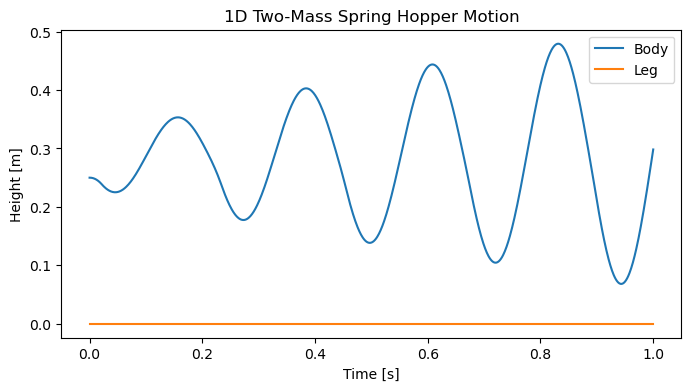

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dynamics import hopper_compression, hopper_flight, hopper_uploading

# --- Simulation ---
dt = 0.001
t_max = 1.0
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

# initial state
x = np.zeros((steps, 4))
x[0] = x0

if x0[2] > 0:
    phase = "flight"
elif x0[0] < L0:
    phase = "compression"
else:
    phase = "uploading"


for i in range(1, steps):
    if phase == "flight":
        dx = hopper_flight(t[i-1], x[i-1], m_b, m_l, L0, k, g)
        x[i] = x[i-1] + np.array(dx) * dt
        # landing condition
        if x[i,2] <= 0:
            x[i,2] = 0
            phase = "compression"
            print(f"Landing at {t[i]:.3f}s")

    elif phase == "compression":
        dx = hopper_compression(t[i-1], x[i-1], m_b, m_l, L0, k, g)
        x[i] = x[i-1] + np.array(dx) * dt

        # prevent body from going below ground
        if x[i,0] < 0:
            x[i,0] = 0
            x[i,1] = 0

        # when spring reaches max compression (yb < L0), switch to uploading
        if x[i,0] <= L0 * 0.8:
            phase = "uploading"
            print(f"Compression complete at time {t[i]:.3f}s with body height {x[i,0]:.3f}m")

    elif phase == "uploading":
        dx = hopper_uploading(t[i-1], x[i-1], m_b, m_l, L0, k, g)
        x[i] = x[i-1] + np.array(dx) * dt

        # when spring fully extends (no more compression)
        spring_force = k * (L0 - (x[i,0] - x[i,2]))
        if spring_force <= 0 and x[i,1] > 0:
            phase = "flight"
            print(f"Takeoff at {t[i]:.3f}s, v={x[i,1]:.3f} m/s")

# --- Plot ---
yb, _, yl, _ = x.T
plt.figure(figsize=(8,4))
plt.plot(t, yb, label="Body")
plt.plot(t, yl, label="Leg")
plt.xlabel("Time [s]")
plt.ylabel("Height [m]")
plt.legend()
plt.title("1D Two-Mass Spring Hopper Motion")
plt.show()

Simulate:

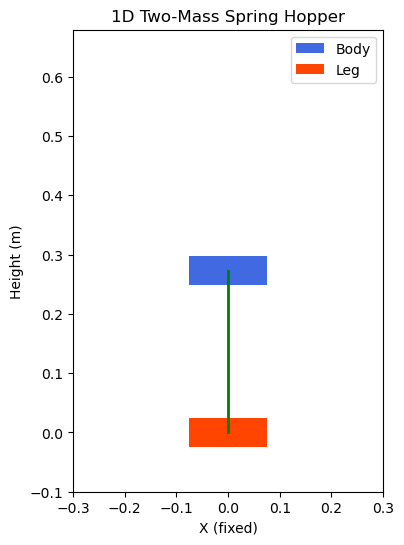

In [7]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML

# --- Animation setup ---
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.1, max(yb) + 0.2)
ax.set_xlabel("X (fixed)")
ax.set_ylabel("Height (m)")
ax.set_title("1D Two-Mass Spring Hopper")

# --- Define body and leg as rectangles ---
body_height, leg_height = 0.05, 0.05
body_width, leg_width = 0.15, 0.15

body_rect = Rectangle((-body_width/2, yb[0]-body_height/2), body_width, body_height,
                      fc='royalblue', label='Body')
leg_rect = Rectangle((-leg_width/2, yl[0]-leg_height/2), leg_width, leg_height,
                     fc='orangered', label='Leg')

ax.add_patch(body_rect)
ax.add_patch(leg_rect)
spring_line, = ax.plot([0, 0], [yl[0], yb[0]], '-', color='green', lw=2)
ax.legend()

def init():
    body_rect.set_xy((-body_width/2, yb[0]-body_height/2))
    leg_rect.set_xy((-leg_width/2, yl[0]-leg_height/2))
    spring_line.set_data([0, 0], [yl[0], yb[0]])
    return body_rect, leg_rect, spring_line

def update(i):
    # update body position
    body_rect.set_xy((-body_width/2, yb[i]-body_height/2))
    # update leg position
    leg_rect.set_xy((-leg_width/2, yl[i]-leg_height/2))
    # update spring
    spring_line.set_data([0, 0], [yl[i], yb[i]])
    return body_rect, leg_rect, spring_line

ani = FuncAnimation(
    fig,
    update,
    frames=range(0, steps, 5),
    init_func=init,
    blit=True,
    interval=dt*1000
)

HTML(ani.to_jshtml())
